# Import the libraries 

In [1]:
from tensorflow import keras
import tensorflow as tf
from keras.models import Model
from keras import Input
from keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import graphviz
import sys
import os
import cv2

# Data load

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-06-29 14:49:47.054225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-29 14:49:47.066108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-29 14:49:47.066359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
train_imgs = sorted(os.listdir('/home/pl/Documents/practice_data/train'))
train_cleaned_imgs = sorted(os.listdir('/home/pl/Documents/practice_data/train_cleaned'))
test_imgs = sorted(os.listdir('/home/pl/Documents/practice_data/test'))

# Data preprocessing

In [4]:
train_img = cv2.imread('/home/pl/Documents/practice_data/train/101.png')
train_img_arr = np.asarray(train_img, dtype="float32")
train_resize_img = cv2.resize(train_img_arr, (540, 420))
train_reshape_img = np.reshape(train_resize_img, (420, 540,3))

In [5]:
train_cleaned_img = cv2.imread('/home/pl/Documents/practice_data/train_cleaned/101.png')
train_cleaned_img_arr = np.asarray(train_cleaned_img, dtype="float32")
train_cleaned_resize_img = cv2.resize(train_cleaned_img_arr, (540, 420))
train_cleaned_reshape_img = np.reshape(train_cleaned_resize_img, (420, 540,3))

In [6]:
test_img = cv2.imread('/home/pl/Documents/practice_data/test/1.png')
test_img_arr = np.asarray(test_img, dtype="float32")
test_resize_img = cv2.resize(test_img_arr, (540, 420))
test_reshape_img = np.reshape(test_resize_img, (420, 540,3))

In [10]:
train = []
train_cleaned = []
test = []

for i in train_imgs:
    train.append(train_reshape_img)
    
for i in train_cleaned_imgs:
    train_cleaned.append(train_cleaned_reshape_img)
    
for i in test_imgs:
    test.append(test_reshape_img)

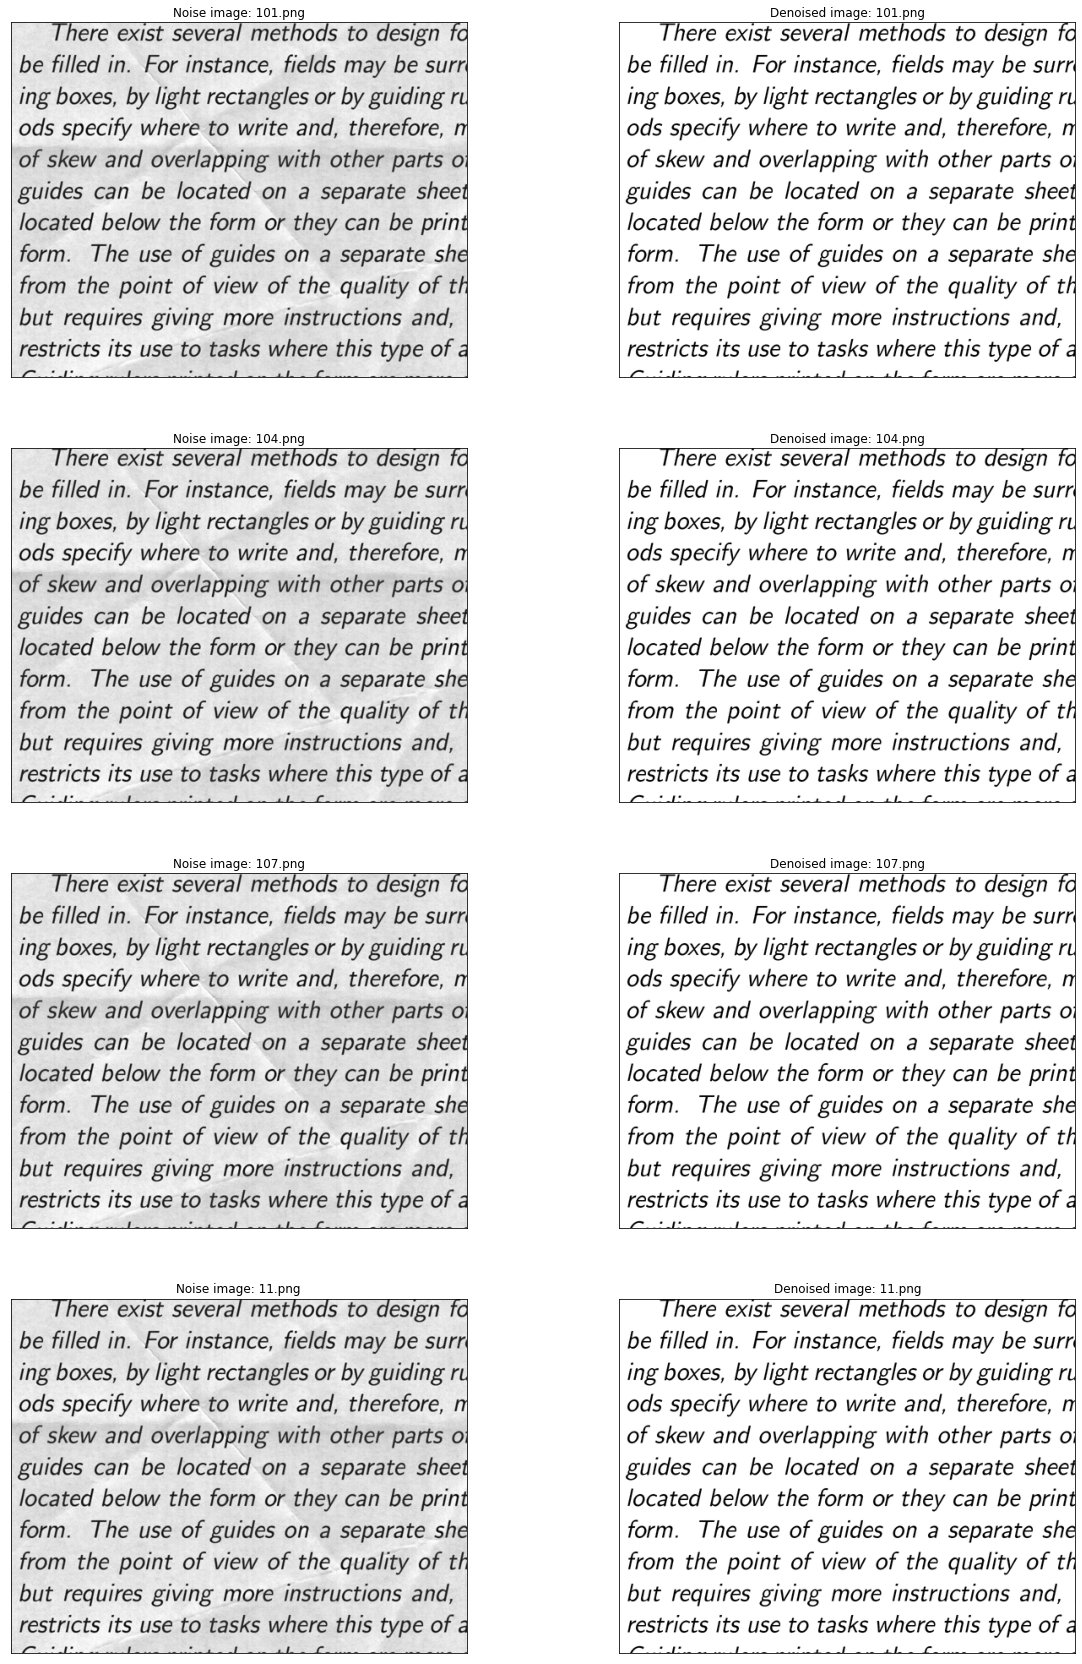

In [8]:
plt.figure(figsize=(20,30))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_imgs[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_imgs[i]))

plt.show()

# Split data

In [14]:
from sklearn.model_selection import train_test_split

X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned[1:])
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.15)